In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style('white')
sns.set_context('poster')

colors = sns.color_palette("deep", 10)
sns.set_palette(colors)


# Solutions: Neural Networks and Deep Learning

In this notebook, we will scratch the surface of using neural networks and deep learning. We will mostly use the one model for this that is implemented in scikit-learn (at the time of writing this workshop), because then we are not distracted by interfacing and API issues and can focus on what we are trying to do. In the instruction notebook, there is an overview of how to solve one of the last of the exercises here with Tensorflow, a widely used general-purpose package for deep neural networks. Other often used packages are theano and keras. For all three, and for doing machine learning in general, the law of conservation of misery holds: if you want to be able to tweak more and be more flexible, it will come at the cost of a more complicated interface, for which you will have to specify more manually.

## The MNIST handwritten digits

There is a famous data set of hand written digits that are labeled. It's called MNIST and is famous enough to have a fetcher function in sklearn.datasets. We will first work with a smaller version of the data set, that came with the workshop material:

In [2]:
digitfile = 'data/digits_train_sample.csv'

digits = pd.read_csv(digitfile)
digits.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


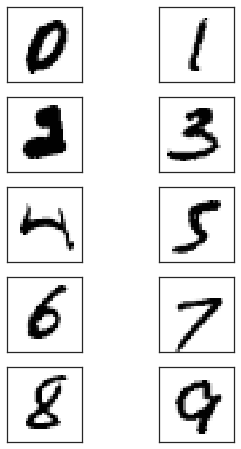

In [3]:
# You might notice that there are 784 pixels, which happens to be 28**2, which is the shape of the images
imsize = 28

# Let's plot a random example of each one - Running this a few times will give you different images each time! 
plt.figure(figsize=[5, 8])
for target in range(10):
    deze = np.random.choice(digits[digits.label == target].index)
    number = np.reshape(np.array(digits[digits.index == deze])[0][1:], [imsize, imsize])
    pp = plt.subplot(5, 2, target+1)
    pp.imshow(number, cmap='Greys')
    pp.set_xticklabels([])
    pp.set_yticklabels([])
  

For some good practice with pandas-like data sets, please create similar thumbnail images of all digits, now showing the average image per label.

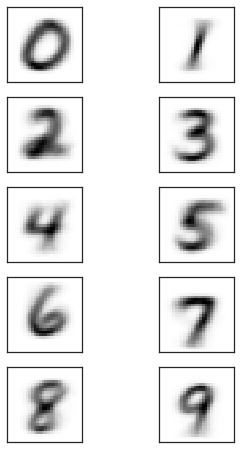

In [4]:
pertarget = digits.groupby('label')
avpixels = pertarget.mean()

plt.figure(figsize=[5, 8])
for target in range(10):
    number = np.reshape(np.array(avpixels[avpixels.index == target])[0], [imsize, imsize])
    pp = plt.subplot(5, 2, target+1)
    pp.imshow(number, interpolation='nearest', cmap='Greys')
    pp.set_xticklabels([])
    pp.set_yticklabels([])

Let's transform the pandas data frames into the data structures that scikit-learn likes more:

In [5]:
labels = digits.label
features = digits.iloc[:,1:]

So, with all the experience you have by now, you should be able to run a quick logistic regression model. It should predict the labels given the features. Score on both training and test data and have a look at the confusion matrix (a matrix of predicted label versus real label), make a plot of that and see if you can to an extent explain the appearance of it.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

xtr, x, ytr, y = train_test_split(features, labels, test_size=0.3)
clf = LogisticRegression()

In [7]:
clf.fit(xtr, ytr)
print(clf.score(xtr, ytr))
print(clf.score(x, y))

1.0
0.811666666667


/home/marcel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


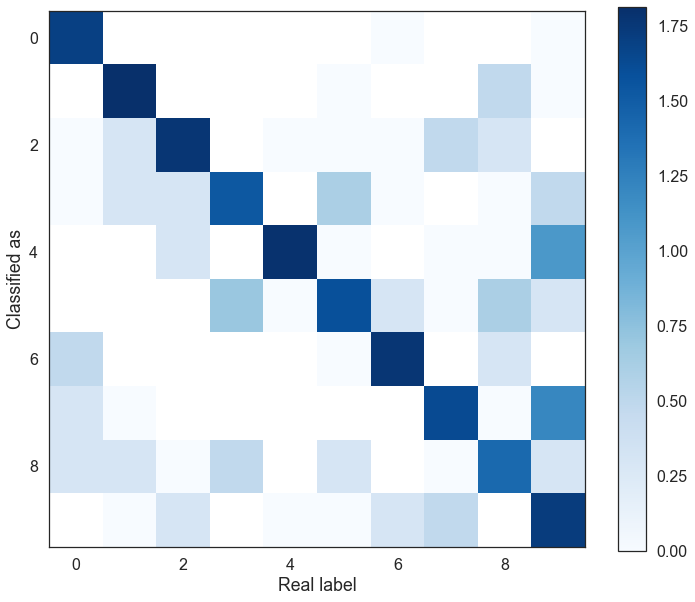

In [8]:
plt.figure(figsize=(12, 10))
plt.imshow(np.log10(confusion_matrix(y, clf.predict(x))), interpolation='nearest', cmap='Blues')
plt.xlabel("Real label")
plt.ylabel("Classified as")
plt.colorbar()

The logistic regression does a decent job on the test sample, but seems to be overfitting. 

*Question 1*: What does that mean, and how can you see that from the above results?

*Question 2*: Why would you not necessarily expect a logistic regression to perform extremely well on a problem like this?

**1:** Overfitting means that the model adapted to some very specific "noise-like" features in the training set.

**2:** A logistic regression assumes two things, which may both be questionable:
- Independence of features: The neighbors of one pixel (on the image) are correlated. When one pixel is not empty, at least some of its neighbors are very likely to be non-zero as well.
- It's a linear model: There is an assumed linear relation between input features and output features (the 10 probabilities), via the link function. Translation and rotation of the images are not at all captured by this.



With the arsenal of methods we have seen before, we can try to see if there is any structure in the data anyway.  Try a PCA, as well as a 2-component t-SNE to see if there is structure in the data. For the PCA case: can you identify the two principle components in vague descriptions? 

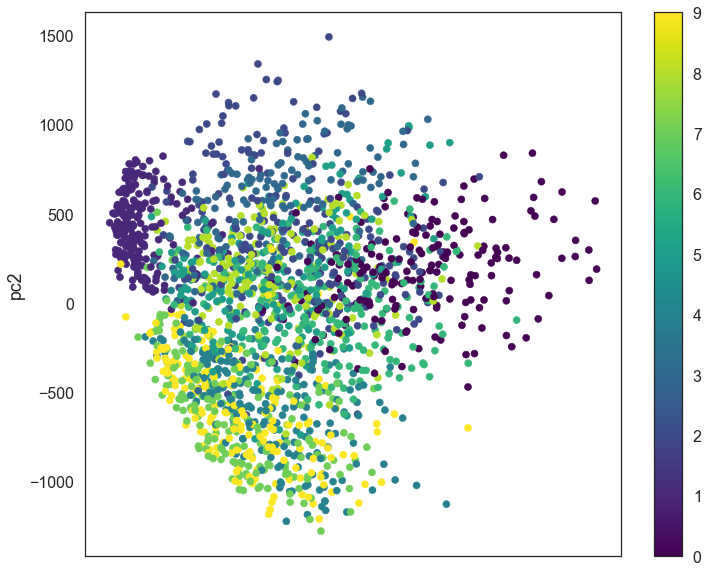

In [9]:
from sklearn.decomposition import PCA
tr = PCA(n_components=2)
pcs = tr.fit_transform(features)

pcf = pd.DataFrame(pcs, index=labels, columns=['pc1', 'pc2'])
# pcf['kleur'] = [kleuren[a] for a in pcf.index]

pcf.plot.scatter(x='pc1', y='pc2', c=pcf.index, s=50, colormap='viridis', figsize=(12,10))

The easily recognizable stuff on the left are the ones. Zeroes start in the middle and extent to the right. The first component seems related to the width of the digit. Vertically, there seems to be some information in the shape of the digits, maybe.

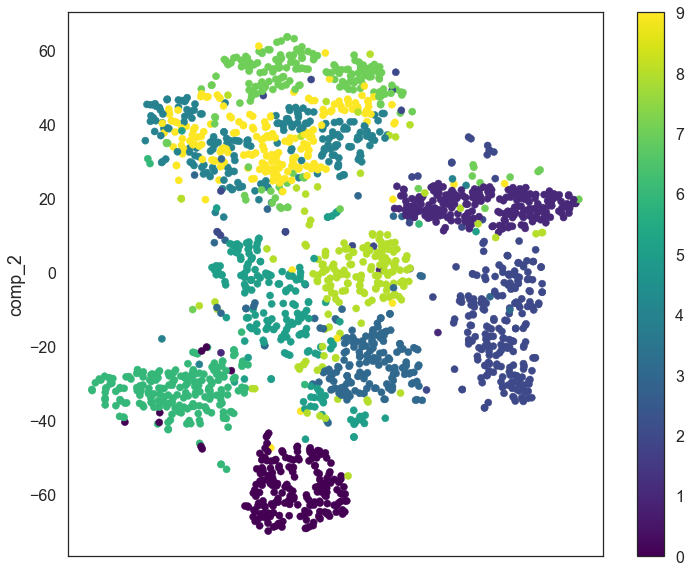

In [10]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

ts = tsne.fit_transform(features)
tf = pd.DataFrame(ts, index=labels, columns=['comp_1', 'comp_2'])

plt.figure(figsize=(12, 10))
tf.plot.scatter(x='comp_1', y='comp_2', c=tf.index, s=50, colormap='viridis', figsize=(12,10))

Alright, let's do neural networks. Neural networks do better with bigger data sets. Therefore, we will use the data fetcher and get a bigger data set of digits, that apart from the data structure it is in, is extremely similar to the data used above. Now that you have seen the fetcher before, try to figure how to do this yourself. If necessary, use google, the docs, etc. If all else fails, there's always the solutions notebook.

So, go ahead and fetch the data, and create an array of features and labels in the same units as above.

In [11]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original", data_home='./data/')  # Data stored in subdirectory data

X, y = mnist.data / 255., mnist.target

Consequently, create a train and test set and in order to have a fair comparison to the exercise above, run a logistic regression on this data as well. Think about the difference in results for a bit. Why is $R^2$ significantly higher with this bigger data set?

In [12]:
xtr, x, ytr, y = train_test_split(X, y, test_size=0.3)
clf = LogisticRegression()
clf.fit(xtr, ytr)
print(clf.score(xtr, ytr))
print(clf.score(x, y))

0.928102040816
0.918761904762


Finally, onto the neural networks. sklearn.neural_network as the Multi-layer Perceptron model, which can do traditional, as well as deep neural networks. Have a look at the docs.

Set up a MLPClassifier for the digits with one layer. Score on train and test data. Then play with the number of neurons of the one hidden layer, vary it strongly (go below ten, as well as far above) and investigate the results. 

In [13]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier()#hidden_layer_sizes=(50,), max_iter=100, alpha=1e-4,
#                     solver='sgd', verbose=50, tol=1e-4, random_state=1,
#                     learning_rate_init=.1 )

In [14]:
mlp.fit(xtr, ytr)
mlp.score(x, y)

0.97733333333333339

In [15]:
np.shape(x)

(21000, 784)

Now train a deep network, with three layers. You should be able to get the $R^2$ close to 98%. Good luck!

In [16]:
mlp = MLPClassifier(hidden_layer_sizes=(200, 50, 50), max_iter=100, alpha=1e-4,
                    solver='sgd', verbose=50, tol=1e-4, random_state=1,
                    learning_rate_init=.1 )

In [17]:
mlp.fit(xtr, ytr)
mlp.score(x, y)

Iteration 1, loss = 0.44095022
Iteration 2, loss = 0.12495888
Iteration 3, loss = 0.08811705
Iteration 4, loss = 0.06852158
Iteration 5, loss = 0.05239482
Iteration 6, loss = 0.04297138
Iteration 7, loss = 0.03971546
Iteration 8, loss = 0.03242699
Iteration 9, loss = 0.03094359
Iteration 10, loss = 0.02246993
Iteration 11, loss = 0.02235028
Iteration 12, loss = 0.02313054
Iteration 13, loss = 0.02102473
Iteration 14, loss = 0.01664029
Iteration 15, loss = 0.01551753
Iteration 16, loss = 0.01913780
Iteration 17, loss = 0.01555304
Iteration 18, loss = 0.01149153
Iteration 19, loss = 0.01010851
Iteration 20, loss = 0.01442025
Iteration 21, loss = 0.01269161
Iteration 22, loss = 0.00678067
Iteration 23, loss = 0.00926228
Iteration 24, loss = 0.01089323
Iteration 25, loss = 0.01278253
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


0.97652380952380957

## Auto-encoding

Deep networks, with layers halfway that consist of few neurons can be used as a dimension reduction tool. After all, if the score fo the full network is X, all that information reaches the output, *through* that layer of few neurons, which, therefore, must contain at least contain the information to recover a fraction X of all true labels.

These images contain 784 pixels, but as it will turn out, a model score of 95% can be reached with a deep "auto-encoding" neural network that has a middle layer of just 2 neurons! One way to reduce data volumes would be to keep only 2 numbers (the output value of the layer of two neurons) and the weights for the network that goes back up to the output scheme.

Train an auto-encoder, that has at least one layer, somehwere, with almost 2 neurons. Get the score on the output well above 90% (on unseen data). When you get that working, use the .coefs\_ attribute and their documentation to find output of the layer of 2 neurons and plot those two "components" as a scatter plot. Discuss with yourself and neighbors what you could do with this.

In [18]:
mlp = MLPClassifier(hidden_layer_sizes=(200, 50, 2, 50, 200), random_state=1, activation='relu')
mlp.fit(xtr, ytr)
mlp.score(x, y)

0.96323809523809523

In [19]:
# Extract the "output" value of theneurons for all digits:
layers = [xtr]
for i in range(mlp.n_layers_-1):
    layers.append(np.dot(layers[i], mlp.coefs_[i]))

The middle layer has shape (49000, 2) and still has at least 95% of the information in the digits! (To recover labels, that is...)


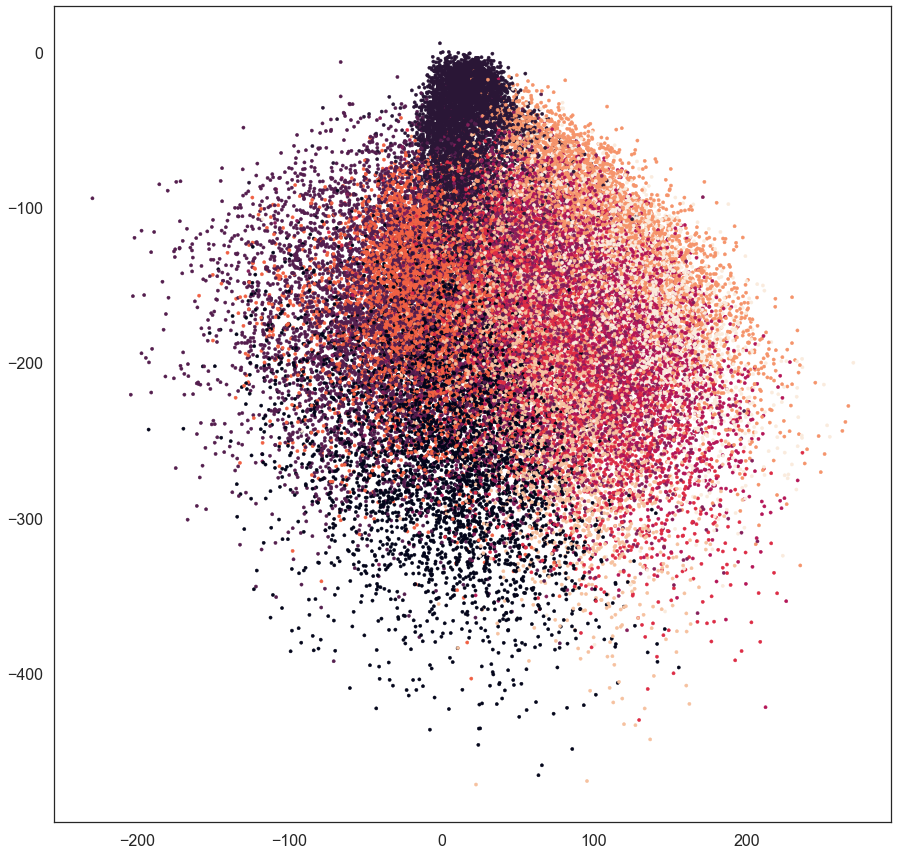

In [20]:
print("The middle layer has shape", np.shape(layers[3]), 
      "and still has at least 95% of the information in the digits! (To recover labels, that is...)")
plt.figure(figsize=(15, 15))
plt.scatter(layers[3][:,0], layers[3][:,1], s=10, c=ytr);

## Bonus exercise

There is no recipe. There is no cookbook. Play around (either by hand, or with grid search) with some hyperparameters and see if you can get a better score (also without the auto-encoding). Typically, to get over 99% (and, therefore, to even remotely have a chance to compete with pride on Kaggle) you will have to do feature engineering. The images are not in their best shape as they are. You could sit here for another few days and try stuff. Why don't you try something you like?

** * Only read on if you want a spoiler-like hint * **

If you can't think of anything yourself, here is a suggestion (one that actually should work well, if you do it well). The digits have empty space surrounding them on the images, both vertically and horizontally. If you remove all empty columns and rows, you will end up with images of different shapes (especially those with a 1 will be quite narrow). Reshape (interpolate, whatever you seem fit) to get them back to the original size (ones will become mostly black) them back to the original size and fit another neural network (deep, with many neurons in the first hidden layer) on this data set. That should already help. If you want even more, you could think of an "orientation correction", that first gets all images aligned, which helps especially for narrow images again.

There are no solutions to this, because there is way too much freedom in here. For inspiration and further practice, see [the kaggle page of this data set](https://www.kaggle.com/c/digit-recognizer/kernels). In the instruction notebook there is an example of doing something like this using TensorFlow, which is more versatile, but also more difficult to use, than what is done here.